Цель работы - анализ предложений по аренде квартир в двух районах Москвы.
Были выбраны два района - Академический и Выхино-Жулебино. В качестве источника данных использовался сайт cian.ru
Для данных о годе постройки дома использовалиьс данные с сайта
Был написан парсер для получения данныз с сайта циан

In [ ]:
import requests
import time
from bs4 import BeautifulSoup

BASE_URL = "https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&in_polygon%5B1%5D=37.787165_55.675748%2C37.787165_55.721493%2C37.864834_55.721493%2C37.864834_55.675748%2C37.787165_55.675748&offer_type=flat&p={page}&polygon_name%5B1%5D=район+Выхино-Жулебино&type=4"
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/123.0.0.0 Safari/537.36"
    )
}
output_file = "cian_flats.html"
with open(output_file, "w", encoding="utf-8") as f:
    for page in range(1, 8):
        url = BASE_URL.format(page=page)
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, "html.parser")
        divs = soup.find_all("div", {"data-name": "LinkArea"})
        for div in divs:
            f.write(div.prettify())
            f.write("\n\n")
        sleep_time = 3 + (page % 3)
        time.sleep(sleep_time)
print("Ok")



Полученные данные в формате html были обработаны и переведены в табличный формат


In [ ]:
from bs4 import BeautifulSoup
import csv, re
from datetime import datetime

def clean_text(s):
    return ' '.join(s.split()) if isinstance(s, str) else s

def clean_price(p):
    if not p or p == 'Не указана': return None
    try: return int(re.sub(r'[^\d]', '', p))
    except: return None

def has_technical_info(text):
    return bool(text and re.search(r'(\d+-комн|\d+\s*м²|\d+/\d+\s*этаж|квартира)', text, re.I))

def parse_technical_info(text):
    if not text: return ("Не указано",) * 4
    m = re.search(r'(\d+)-комн.*?(\d+)\s*м².*?(\d+)\s*/\s*(\d+)\s*этаж', text)
    if m:
        return f"{m[1]}-комн.", f"{m[2]} м²", m[3], m[4]
    rooms = re.search(r'(\d+)-комн', text)
    area = re.search(r'(\d+)\s*м²', text)
    floor = re.search(r'(\d+)\s*(?:из|/)\s*(\d+)\s*этаж', text)
    return (
        f"{rooms[1]}-комн." if rooms else "Не указано",
        f"{area[1]} м²" if area else "Не указано",
        floor[1] if floor else "Не указано",
        floor[2] if floor else "Не указано"
    )


def parse_cian_flats(html):
    soup = BeautifulSoup(html, 'html.parser')
    flats = []
    for c in soup.select('div._93444fe79c--container--kZeLu._93444fe79c--link--DqDOy'):
        title = c.find('span', {'data-mark': 'OfferTitle'})
        sub = c.find('span', {'data-mark': 'OfferSubtitle'})
        parse_text = sub.get_text(strip=True) if sub and not has_technical_info(title.get_text()) else (title.get_text(strip=True) if title else "")
        rooms, area, fl, flt = parse_technical_info(parse_text)

        metro = c.find('div', class_='_93444fe79c--container--w7txv')
        metro_name = metro.find('div', string=re.compile(r'[А-Яа-я]')).get_text(strip=True) if metro else "Не указано"
        metro_dist = metro.find('div', class_='_93444fe79c--remoteness--q8IXp')
        metro_dist = metro_dist.get_text(strip=True) if metro_dist else "Не указано"

        addr = c.find('div', class_='_93444fe79c--labels--L8WyJ')
        address = ', '.join(a.get_text(strip=True) for a in addr.find_all('a')) if addr else "Не указан"

        price = c.find('span', {'data-mark': 'MainPrice'})
        price_info = c.find('p', {'data-mark': 'PriceInfo'})
        desc = c.find('div', {'data-name': 'Description'})
        link = c.find('a', class_='_93444fe79c--link--eoxce')

        flats.append({
            'rooms': rooms,
            'area': area,
            'current_floor': fl,
            'total_floors': flt,
            'floor_info': f"{fl}/{flt}" if fl != "Не указано" else "Не указано",
            'metro': metro_name,
            'metro_distance': metro_dist,
            'address': address,
            'price': price.get_text(strip=True) if price else "Не указана",
            'price_clean': clean_price(price.get_text(strip=True) if price else None),
            'price_info': price_info.get_text(strip=True) if price_info else "",
            'description': clean_text(desc.get_text(strip=True)) if desc else "",
            'link': link['href'] if link else "",
            'parsed_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        })
    return flats

def save_to_csv(flats, filename='cian_flats.csv'):
    if not flats:
        return print("Нет данных для сохранения")
    with open(filename, 'w', newline='', encoding='utf-8-sig') as f:
        writer = csv.DictWriter(f, fieldnames=flats[0].keys())
        writer.writeheader()
        for flat in flats:
            flat['description'] = (flat['description'][:200] + '...') if len(flat['description']) > 200 else flat['description']
            writer.writerow({k: clean_text(str(v)) for k, v in flat.items()})
    print(f"✅ Сохранено {len(flats)} квартир в {filename}")

def main():
    with open('cian_flats - A.txt', 'r', encoding='utf-8') as f:
        flats = parse_cian_flats(f.read())
    save_to_csv(flats)

if __name__ == '__main__':
    main()



Для изучения таблиц были сделаны SQL-запросы

Средняя цена по комнатам

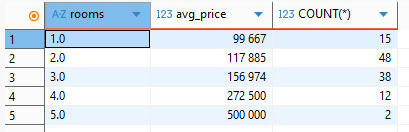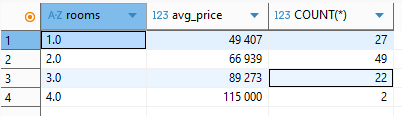

In [ ]:
SELECT
    rooms,
    ROUND(AVG(price_clean), 0) AS avg_price,
    COUNT(*) 
FROM cian
WHERE rooms >= 1
GROUP BY rooms
ORDER BY rooms

Средняя цена по этажам

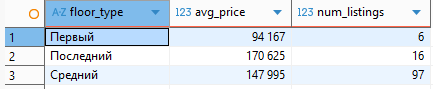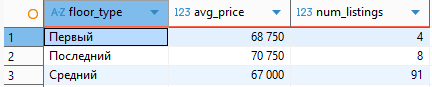


In [ ]:
SELECT
    CASE
        WHEN current_floor = 1 THEN 'Первый'
        WHEN current_floor = total_floors THEN 'Последний'
        ELSE 'Средний'
    END AS floor_type,
    ROUND(AVG(price_clean), 0) AS avg_price,
    COUNT(*) AS num_listings
FROM cian
GROUP BY floor_type

Топ 5 самых дорогих квартир

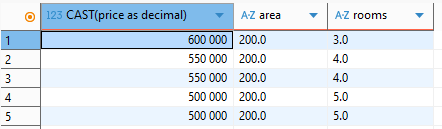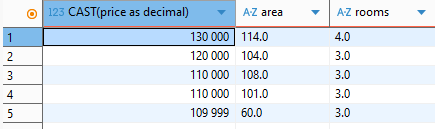

In [ ]:
SELECT CAST(price as decimal), area, rooms
FROM cian 
ORDER BY CAST(price as decimal) DESC
LIMIT 5

Видно, что в Академическом районе присутствуют крайне дорогие квартиры, в районе Выхино-Жулебино такого не наблюдается

С помощью библиотек python были построены графики для визуализации

Средняя цена в зависимости от числа комнат сотсечкой 5% самых дорогих и самых дешёвых квартир и без неё

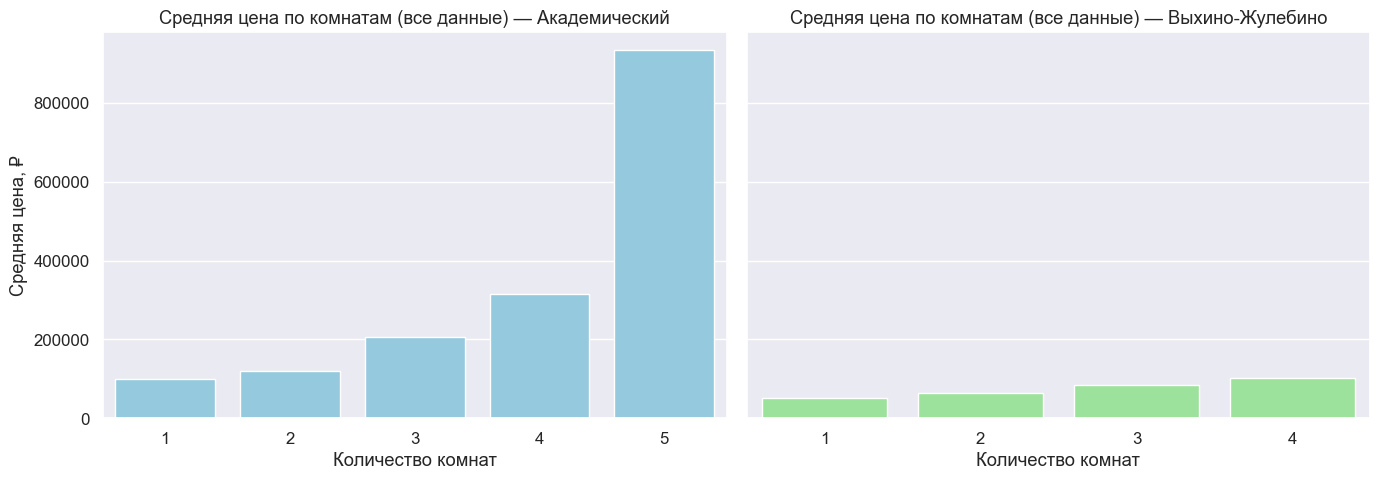

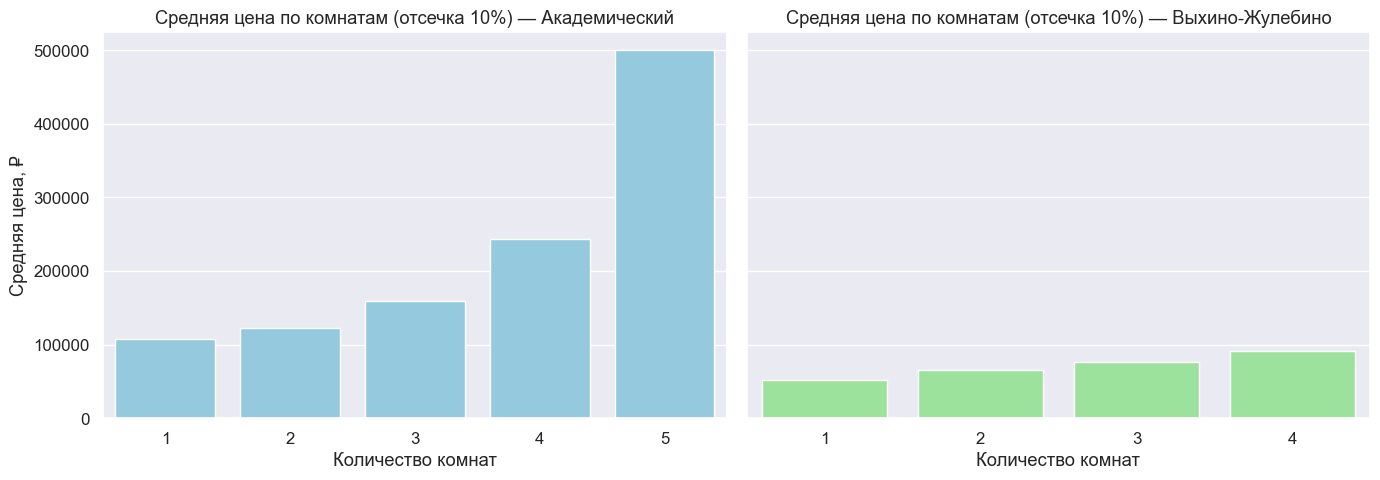

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
plt.style.use("ggplot")
sns.set(font_scale=1.1)
pd.options.display.float_format = '{:,.0f}'.format
def clean_rooms(value):
    if pd.isna(value):
        return np.nan
    val = str(value).strip().lower()
    if "студ" in val:
        return 0
    match = re.search(r"\d+", val)
    if match:
        return int(match.group(0))
    return np.nan
def prepare_df(df):
    df = df.dropna(subset=["rooms", "area", "price_clean", "current_floor", "total_floors", "metro_distance"])
    df = df[df["price_clean"] > 0]
    df["rooms_clean"] = df["rooms"].apply(clean_rooms)
    df = df.dropna(subset=["rooms_clean"])
    df["rooms_clean"] = df["rooms_clean"].astype(int)
    return df
def avg_price_by_rooms(df, trim_quantiles=None):
    if trim_quantiles:
        low, high = df["price_clean"].quantile(trim_quantiles)
        df = df[(df["price_clean"] >= low) & (df["price_clean"] <= high)]
    avg = df.groupby("rooms_clean")["price_clean"].mean().reset_index()
    avg = avg.sort_values("rooms_clean")
    return avg
def plot_two_dfs(avg1, avg2, labels=("DF1", "DF2"), title="Средняя цена по комнатам"):
    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

    # Используем color вместо palette, чтобы убрать предупреждение
    sns.barplot(data=avg1, x="rooms_clean", y="price_clean", ax=axes[0], color="skyblue")
    axes[0].set_title(f"{title} — {labels[0]}")
    axes[0].set_xlabel("Количество комнат")
    axes[0].set_ylabel("Средняя цена, ₽")

    sns.barplot(data=avg2, x="rooms_clean", y="price_clean", ax=axes[1], color="lightgreen")
    axes[1].set_title(f"{title} — {labels[1]}")
    axes[1].set_xlabel("Количество комнат")
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()

df1 = pd.read_csv("cian_flats.csv")
df2 = pd.read_csv("cian_flats-B.csv")  
df1 = prepare_df(df1)
df2 = prepare_df(df2)
avg1 = avg_price_by_rooms(df1)
avg2 = avg_price_by_rooms(df2)
plot_two_dfs(avg1, avg2, labels=("Академический", "Выхино-Жулебино"), title="Средняя цена по комнатам (все данные)")
avg1_trim = avg_price_by_rooms(df1, trim_quantiles=(0.05, 0.95))
avg2_trim = avg_price_by_rooms(df2, trim_quantiles=(0.05, 0.95))
plot_two_dfs(avg1_trim, avg2_trim, labels=("Академический", "Выхино-Жулебино"), title="Средняя цена по комнатам (отсечка 10%)")


Цена аренды в зависимости от этажа

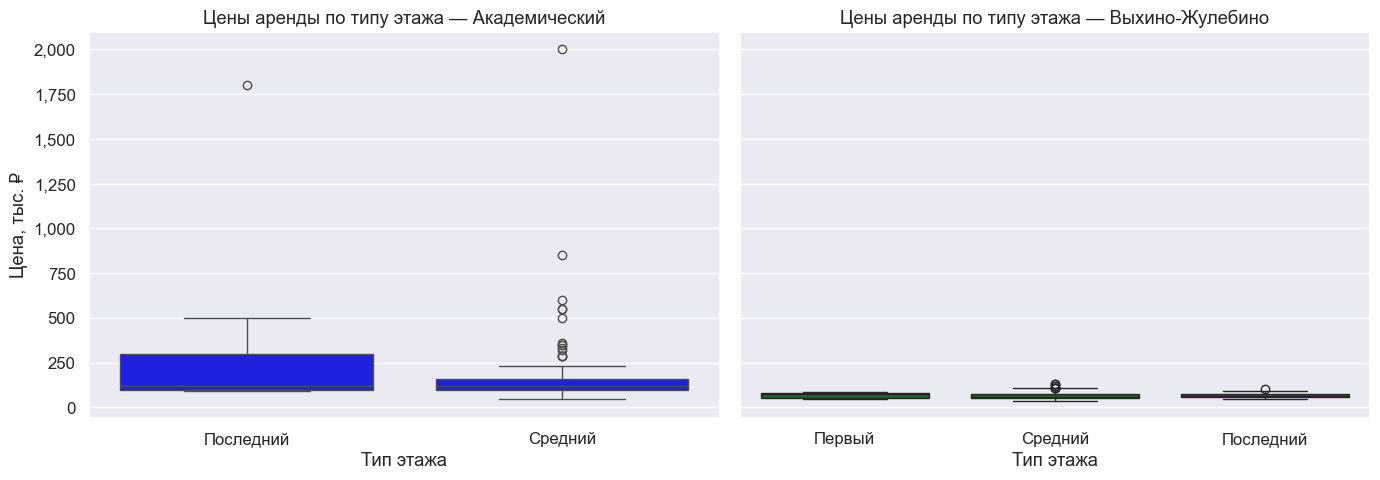

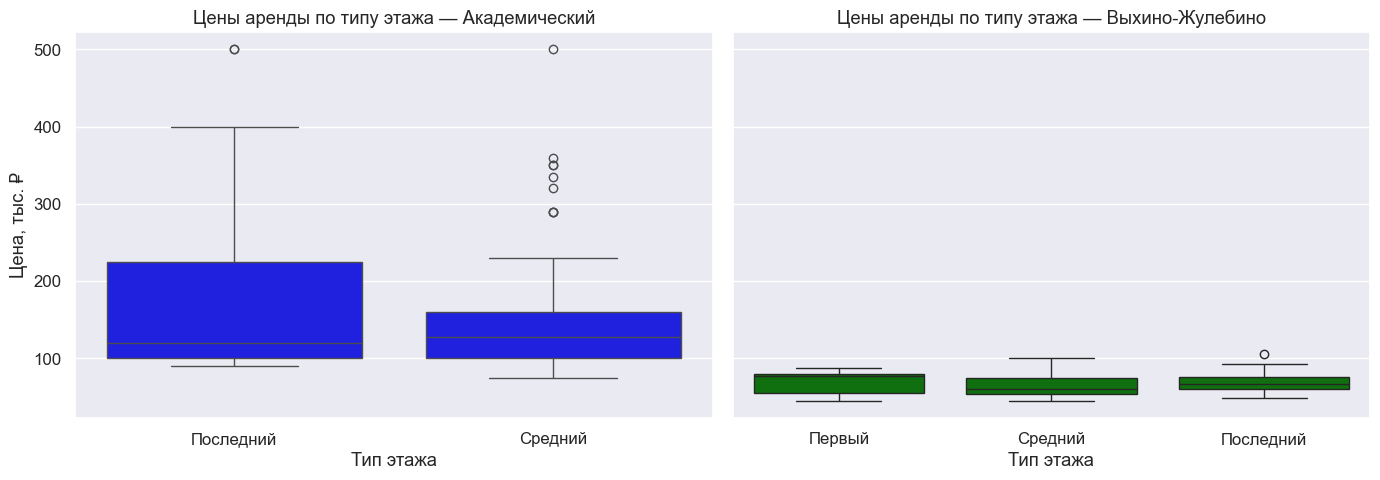

In [ ]:

def floor_type(row):
    if row["current_floor"] == 1:
        return "Первый"
    elif row["current_floor"] == row["total_floors"]:
        return "Последний"
    else:
        return "Средний"
def prepare_floor_df(df):
    df = df[df["price_clean"] > 0].copy()
    df["floor_type"] = df.apply(floor_type, axis=1)
    return df
def plot_floor_comparison(df1, df2, labels=("DF1", "DF2"), trim_quantiles=None):
    dfs = []
    titles = []
    for df, label in zip([df1, df2], labels):
        temp = df.copy()
        if trim_quantiles:
            low, high = temp["price_clean"].quantile(trim_quantiles)
            temp = temp[(temp["price_clean"] >= low) & (temp["price_clean"] <= high)]
            if "Первый" not in temp["floor_type"].unique():
                df_first = df[df["floor_type"] == "Первый"]
                temp = pd.concat([temp, df_first])
        dfs.append(temp)
        titles.append(label)
    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)
    colors = ["blue", "green"]
    for ax, temp_df, color, title in zip(axes, dfs, colors, titles):
        sns.boxplot(
            data=temp_df,
            x="floor_type",
            y="price_clean",
            dodge=False,
            color=color,
            ax=ax
        )
        ax.set_title(f"Цены аренды по типу этажа — {title}")
        ax.set_xlabel("Тип этажа")
        ax.set_ylabel("Цена, тыс. ₽")
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000):,}'))
    
    plt.tight_layout()
    plt.show()

    
df1 = prepare_floor_df(df1)
df2 = prepare_floor_df(df2)
plot_floor_comparison(df1, df2, labels=("Академический", "Выхино-Жулебино"))
plot_floor_comparison(df1, df2, labels=("Академический", "Выхино-Жулебино"), trim_quantiles=(0.05, 0.95))


Цена аренды в зависимости от расстояния до метро

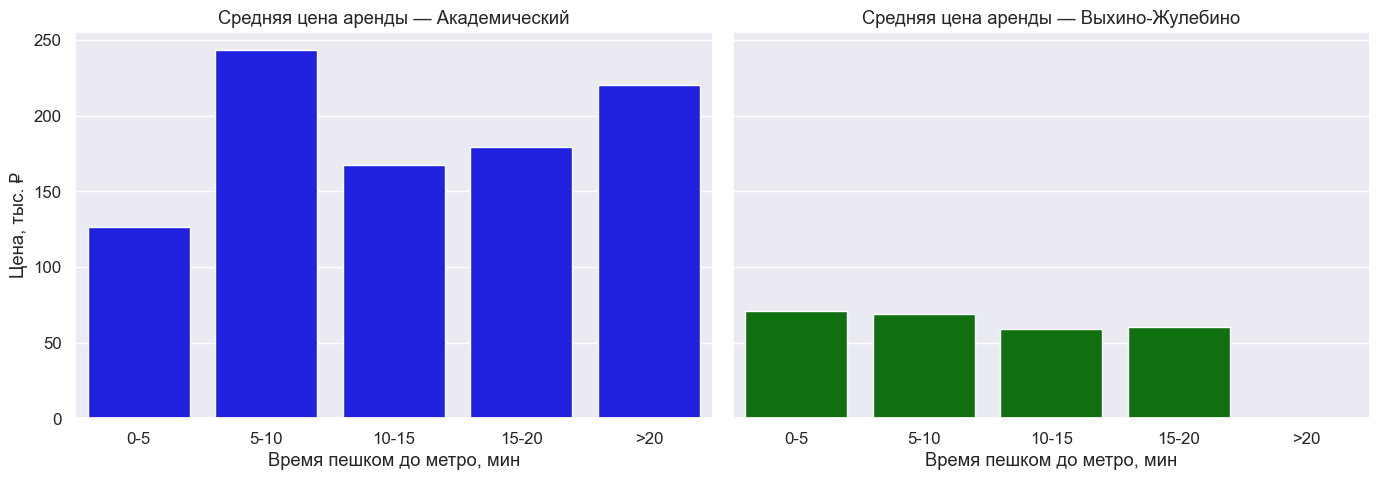

In [107]:
def parse_distance(val):
    if pd.isna(val):
        return np.nan
    val = str(val).strip().lower().replace(" ", "").replace(",", ".")
    match = re.search(r"\d+(\.\d+)?", val)
    if not match:
        return np.nan
    number = float(match.group(0))
    if "км" in val:
        number *= 1000
    return number
def prepare_metro_df(df):
    df_metro = df.copy()
    df_metro["metro_distance_clean"] = df_metro["metro_distance"].apply(parse_distance)
    df_metro = df_metro.dropna(subset=["metro_distance_clean", "price_clean"])
    bins = [0, 5, 10, 15, 20, np.inf]
    labels = ["0-5", "5-10", "10-15", "15-20", ">20"]
    df_metro["metro_time_group"] = pd.cut(
        df_metro["metro_distance_clean"],
        bins=bins,
        labels=labels,
        right=False,
        include_lowest=True
    )
    return df_metro
def avg_price_by_metro(df):
    avg = df.groupby("metro_time_group", observed=True)["price_clean"].mean().reset_index()
    return avg
def plot_metro_comparison(df1, df2, labels=("Академический", "Выхино-Жулебино")):
    df1_clean = prepare_metro_df(df1)
    df2_clean = prepare_metro_df(df2)
    
    avg1 = avg_price_by_metro(df1_clean)
    avg2 = avg_price_by_metro(df2_clean)
    
    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)
    colors = ["blue", "green"]
    
    for ax, avg, color, label in zip(axes, [avg1, avg2], colors, labels):
        sns.barplot(
            data=avg,
            x="metro_time_group",
            y="price_clean",
            color=color,
            dodge=False,
            ax=ax
        )
        ax.set_title(f"Средняя цена аренды — {label}")
        ax.set_xlabel("Время пешком до метро, мин")
        ax.set_ylabel("Цена, тыс. ₽")
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000):,}'))
    plt.tight_layout()
    plt.show()


plot_metro_comparison(df1, df2, labels=("Академический", "Выхино-Жулебино"))


Цена за м² от площади

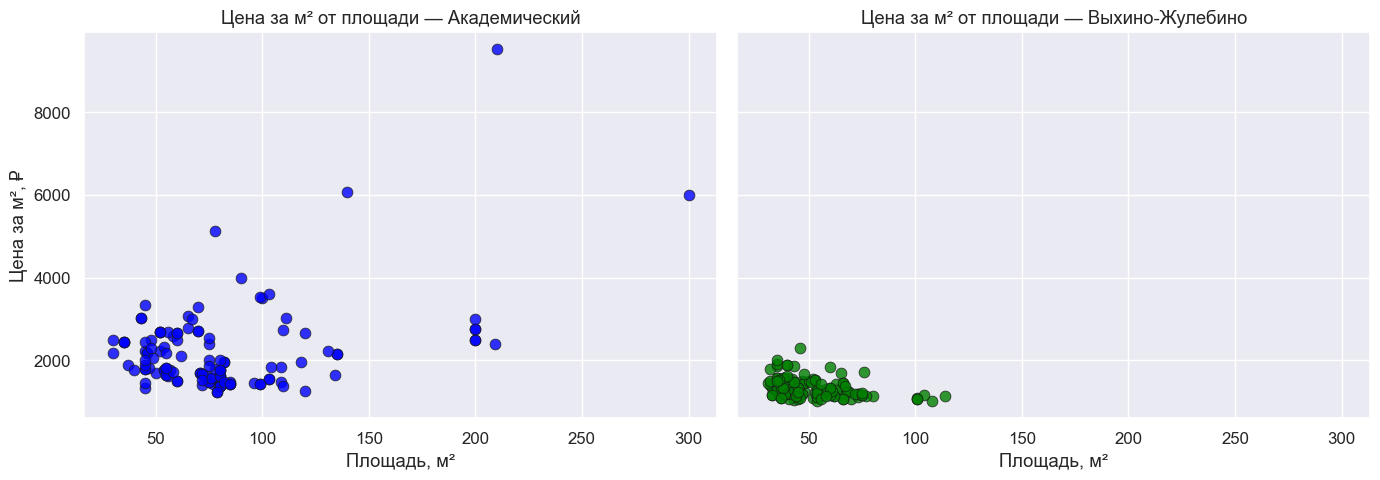

In [113]:
def parse_area(val):
    if pd.isna(val):
        return np.nan
    val = str(val).strip().lower().replace(",", ".").replace(" ", "")
    val = re.sub(r"[^\d.]", "", val)
    if val == "":
        return np.nan
    return float(val)
def prepare_area_df(df):
    df_area = df.copy()
    df_area["area_clean"] = df_area["area"].apply(parse_area)
    df_area = df_area.dropna(subset=["area_clean", "price_clean"])
    df_area = df_area[(df_area["area_clean"] > 10) & (df_area["price_clean"] > 1000)]
    df_area["price_per_m2"] = df_area["price_clean"] / df_area["area_clean"]
    df_area = df_area[df_area["price_per_m2"] > 1000]
    return df_area
def plot_area_comparison(df1, df2, labels=("Академический", "Выхино-Жулебино")):
    df1_clean = prepare_area_df(df1)
    df2_clean = prepare_area_df(df2)
    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True, sharex=True)
    for ax, df_plot, label, color in zip(axes, [df1_clean, df2_clean], labels, ["blue", "green"]):
        sns.scatterplot(
            data=df_plot, 
            x="area_clean", 
            y="price_per_m2", 
            alpha=0.8,   
            s=60,          
            ax=ax, 
            color=color,
            edgecolor="k"   
        )
        ax.set_title(f"Цена за м² от площади — {label}")
        ax.set_xlabel("Площадь, м²")
        ax.set_ylabel("Цена за м², ₽")
    
    plt.tight_layout()
    plt.show()
plot_area_comparison(df1, df2, labels=("Академический", "Выхино-Жулебино"))


Корреляционная матрица

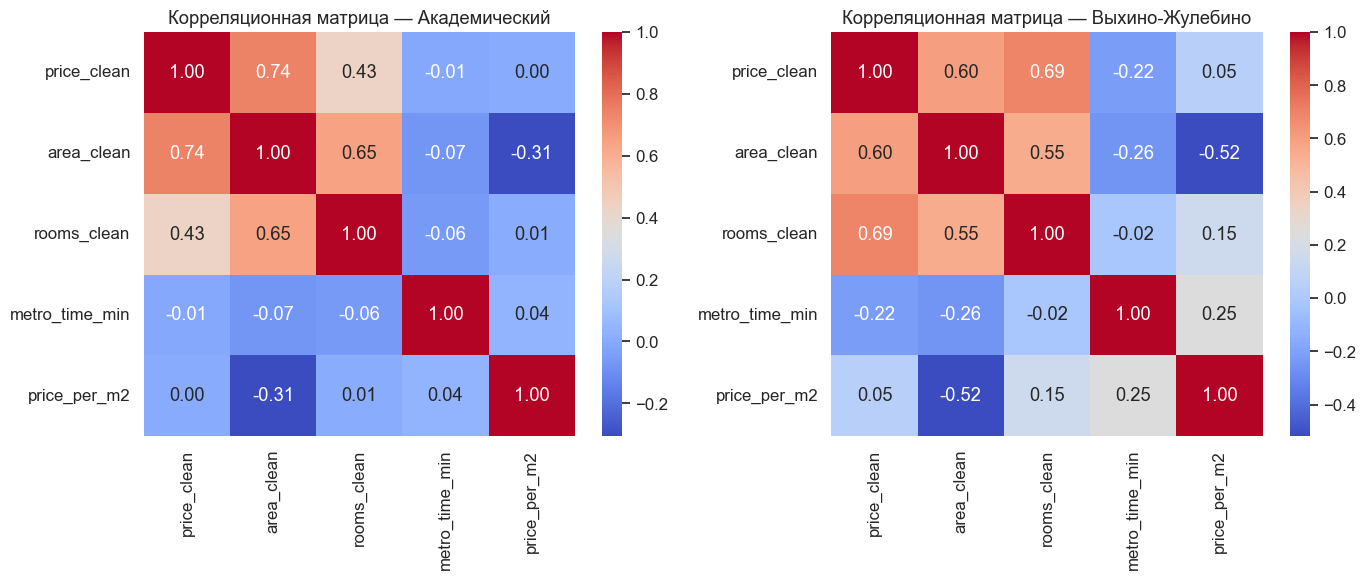

In [109]:
def extract_number(val, multiply_km=False):
    if pd.isna(val):
        return np.nan
    val = str(val).lower().replace(" ", "").replace(",", ".")
    match = re.search(r"\d+(\.\d+)?", val)
    if not match:
        return np.nan
    number = float(match.group(0))
    if multiply_km and "км" in val:
        number *= 1000
    return number
def prepare_corr_df(df):
    df_corr = df.copy()
    df_corr["price_clean"] = df_corr["price_clean"].apply(lambda x: extract_number(x))
    df_corr["area_clean"] = df_corr["area"].apply(lambda x: extract_number(x))
    df_corr["rooms_clean"] = df_corr["rooms"].apply(lambda x: extract_number(x))
    df_corr["metro_time_min"] = df_corr["metro_distance"].apply(lambda x: extract_number(x, multiply_km=True))
    df_corr["price_per_m2"] = df_corr["price_clean"] / df_corr["area_clean"]
    df_corr = df_corr.dropna(subset=["price_clean", "area_clean", "rooms_clean", "price_per_m2"])
    return df_corr
def compute_corr(df):
    numeric_cols = ["price_clean", "area_clean", "rooms_clean", "metro_time_min", "price_per_m2"]
    return df[numeric_cols].corr()
def plot_corr_comparison(df1, df2, labels=("Академический", "Выхино-Жулебино")):
    df1_corr = prepare_corr_df(df1)
    df2_corr = prepare_corr_df(df2)
    
    corr1 = compute_corr(df1_corr)
    corr2 = compute_corr(df2_corr)
    
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    
    sns.heatmap(corr1, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
    axes[0].set_title(f"Корреляционная матрица — {labels[0]}")
    
    sns.heatmap(corr2, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
    axes[1].set_title(f"Корреляционная матрица — {labels[1]}")
    
    plt.tight_layout()
    plt.show()


plot_corr_comparison(df1, df2, labels=("Академический", "Выхино-Жулебино"))
